In [1]:
import os
import numpy as np
import pandas as pd
import selfies
import torch
import chemistry_vae_selfies
import data_loader
import chemistry_perceptron_carlos_implementation as cp
import torch.nn as nn
import yaml
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import time
import importlib
from torcheval.metrics import R2Score


In [2]:
my_file = pd.read_csv('./datasets/QM9listprops.csv', index_col=None)##The file you want to train on, should contain SMILES reps, latent space reps and properties
my_file.dropna()

list_of_properties = []


for i in range(len(my_file)):

    DipoleIn = my_file['dipole_moment'][i]
    GapIn = my_file['energy_gap'][i]
    SMILESCodeIn = my_file['smiles'][i]
    list_of_properties.append([SMILESCodeIn, GapIn, DipoleIn])

In [3]:
# load the encoder and decoder models from the VAE training

folder_path = "./datasets/"
file_name = "SelectedSMILES_QM9.txt"

full_path = folder_path + file_name

selfies_list, selfies_alphabet, largest_selfies_len, smiles_list, smiles_alphabet, largest_smiles_len = chemistry_vae_selfies.get_selfie_and_smiles_encodings_for_dataset(full_path)

#selfies_alphabet = ['[#Branch2]', '[Ring2]', '[Branch2]', '[=Branch2]', '[O]', '[=O]', '[=C]', '[=N]', '[#Branch1]', '[=Branch1]', '[nop]', '[N]', '[Branch1]', '[F]', '[#C]', '[#N]', '[Ring1]', '[C]']

###

    # define source file location
file_to_load =  "./saved_models_RNN/"
    # training file name encoder
training_file_nameE = "300/E"
    # training file name decoder
training_file_nameD = "300/D"
    # load data
    #load_data_trained = file_to_load + training_file_nameE
    # Alphabet has 18 letters, largest molecule is 21 letters. (build this as an output function later ... )
largest_selfies_len_dataset = largest_selfies_len
largest_smiles_len_dataset = largest_smiles_len

    #in_dimension = len(selfies_alphabet)*largest_selfies_len
in_dimension = len(smiles_alphabet)*largest_smiles_len

    # load the trained encoder
vae_encoder = torch.load(file_to_load + training_file_nameE) #, map_location=torch.device(device="cpu"))
    #print(vae_encoder)

    # load the trained decoder
vae_decoder = torch.load(file_to_load + training_file_nameD) #, map_location=torch.device(device="cpu"))
    #print(vae_decoder)


selfies_alphabet = ['[#Branch2]', '[Ring2]', '[Branch2]', '[=Branch2]', '[O]', '[=O]', '[=C]', '[=N]', '[#Branch1]', '[=Branch1]', '[nop]', '[N]', '[Branch1]', '[F]', '[#C]', '[#N]', '[Ring1]', '[C]']

###

--> Translating SMILES to SELFIES...
Finished translating SMILES to SELFIES.
selfies aplhabet: ['[O]', '[=O]', '[F]', '[C]', '[nop]', '[Branch2]', '[#Branch2]', '[Ring1]', '[Branch1]', '[=Branch1]', '[Ring2]', '[=C]', '[=Branch2]', '[#C]', '[N]', '[#N]', '[#Branch1]', '[=N]']
smiles aplhabet: ['O', '3', ')', 'F', '1', '4', '=', 'C', '(', '#', '5', '2', 'N', ' ']


In [4]:
# select the molecules without pentabonds
smiles_rep, latent_rep, props_used = cp.filter(list_of_properties, largest_selfies_len_dataset, selfies_alphabet, vae_encoder, vae_decoder)

vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector skipped
vector ski

In [5]:
# convert to torch tensors and generate latent space vectors

input_dim = 25 ### Size of the latent space

def normalize_tensor(a):
    a_std = a.std()
    a_mean = a.mean()
    return(((a-a_mean)/a_std), a_mean, a_std)


latent_space_vectors_valid = [item[0].detach().squeeze(0) for item in latent_rep]
properties_training = [torch.tensor(property_vector) for property_vector in props_used]  # this will convert lists to tensors

train_size = round(len(latent_space_vectors_valid)*0.9)

energy_gaps = []
for i in range(len(properties_training)):
    energy_gaps.append(props_used[i][0])

energy_gaps, energy_mean, energy_std = normalize_tensor(torch.tensor(energy_gaps))

#energy_gaps = torch.tensor(energy_gaps)

latent_space_vectors_valid = torch.stack(latent_space_vectors_valid)


print(latent_space_vectors_valid.size())
print(energy_gaps.size())

train_latent_space_tensor = latent_space_vectors_valid[:train_size]
test_latent_space_tensor = latent_space_vectors_valid[train_size:]

props_train = energy_gaps[:train_size]
props_test = energy_gaps[train_size:]

train_latent_space_tensor = train_latent_space_tensor.squeeze()
test_latent_space_tensor = test_latent_space_tensor.squeeze()

torch.Size([130251, 1, 25])
torch.Size([130251])


In [163]:
importlib.reload(cp) 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if os.path.exists("settings_perceptron_carlos_implementation.yml"):
    settings = yaml.safe_load(open("settings_perceptron_carlos_implementation.yml", "r"))
else:
    print("Expected a file settings_perceptron_carlos_implementation.yml but didn't find it.")
    
print('--> Acquiring data...')
# set the parameters manualy
hidden_dim = settings['architecture']['hidden_dim'] 
prop_hidden_dim = settings['architecture']['prop_hidden_dim']
prop_pred_activation =  settings['architecture']['prop_pred_activation']
prop_pred_dropout =  settings['architecture']['prop_pred_dropout']
prop_pred_depth = settings['architecture']['prop_pred_depth']
prop_growth_factor =  settings['architecture']['prop_growth_factor']
lr_input= settings['training']['lr']
epochs = settings['training']['num_epochs']
batch_size = settings['data']['batch_size']


# Instantiate the model with hyperparameters
model = cp.PropertyRegressionModel(input_dim, hidden_dim, prop_hidden_dim, prop_pred_activation, prop_pred_dropout, prop_pred_depth, prop_growth_factor)

# Define your loss function (e.g., Mean Squared Error)
#loss_function = nn.L1Loss()
loss_function = nn.MSELoss()

# Define your optimizer (e.g., Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_input)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

lmbda = lambda epoch: 0.94
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
#scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

#define metric 
metric  = R2Score()
metric = metric.to(device)

model = model.to(device)
criterion = loss_function.to(device)


--> Acquiring data...
layer #1 has 512 neurons.
layer #2 has 128 neurons.


In [164]:
import torch.utils.data as data
train_dataset = data.TensorDataset(train_latent_space_tensor, props_train)

valid_dataset = data.TensorDataset(test_latent_space_tensor, props_test)

train_iterator = data.DataLoader(train_dataset,
                                 shuffle=True,
                                 batch_size=batch_size)

valid_iterator = data.DataLoader(valid_dataset,
                                 shuffle=True,
                                 batch_size=batch_size)


In [165]:
# Define training loop

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_r2 =0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x).squeeze()

        loss = torch.sqrt(criterion(y_pred, y))
        
        metric.update(y_pred, y)
        r_2 = metric.compute()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_r2 += r_2.item()

    return epoch_loss / len(iterator), epoch_r2/ len(iterator)


# Define evaluation loop

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_r2 =0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:
            
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x).squeeze()

            loss = torch.sqrt(criterion(y_pred, y))
            #loss = criterion(y_pred, y)
            metric.update(y_pred, y)
            r_2 = metric.compute()

            epoch_loss += loss.item()
            epoch_r2 += r_2.item()

    return epoch_loss / len(iterator), epoch_r2 / len(iterator)


# define epoch time 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


EPOCHS = epochs

best_valid_loss = float('inf')

epoch_losses = []
epoch_r2s = []

for epoch in trange(EPOCHS):

    #start_time = time.monotonic()

    train_loss, r2_train = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, r2_valid = evaluate(model, valid_iterator, criterion, device)
    scheduler1.step()
    epoch_losses.append([train_loss,valid_loss])
    epoch_r2s.append([r2_train,r2_valid])

    #if valid_loss < best_valid_loss:
    #    best_valid_loss = valid_loss
    #    torch.save(model.state_dict(), 'tut1-model.pt')

    #end_time = time.monotonic()

    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    #print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train R^2: {r2_train:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. R^2: {r2_valid:.3f}')



  0%|          | 0/50 [00:00<?, ?it/s]

	Train Loss: 0.959 | Train R^2: -0.675
	 Val. Loss: 0.751 | Val. R^2: -0.017
	Train Loss: 0.733 | Train R^2: 0.134
	 Val. Loss: 0.694 | Val. R^2: 0.228
	Train Loss: 0.701 | Train R^2: 0.282
	 Val. Loss: 0.665 | Val. R^2: 0.323
	Train Loss: 0.679 | Train R^2: 0.354
	 Val. Loss: 0.643 | Val. R^2: 0.379
	Train Loss: 0.664 | Train R^2: 0.398
	 Val. Loss: 0.621 | Val. R^2: 0.416
	Train Loss: 0.653 | Train R^2: 0.430
	 Val. Loss: 0.614 | Val. R^2: 0.443
	Train Loss: 0.644 | Train R^2: 0.454
	 Val. Loss: 0.608 | Val. R^2: 0.464
	Train Loss: 0.637 | Train R^2: 0.473
	 Val. Loss: 0.598 | Val. R^2: 0.481
	Train Loss: 0.631 | Train R^2: 0.488
	 Val. Loss: 0.596 | Val. R^2: 0.495
	Train Loss: 0.626 | Train R^2: 0.501
	 Val. Loss: 0.587 | Val. R^2: 0.507
	Train Loss: 0.623 | Train R^2: 0.512
	 Val. Loss: 0.582 | Val. R^2: 0.517
	Train Loss: 0.619 | Train R^2: 0.521
	 Val. Loss: 0.579 | Val. R^2: 0.526
	Train Loss: 0.615 | Train R^2: 0.530
	 Val. Loss: 0.575 | Val. R^2: 0.533
	Train Loss: 0.611 | Tr

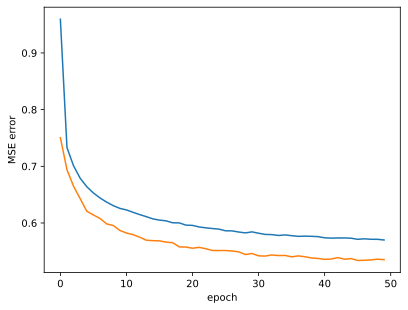

In [166]:
plt.plot([x[0] for x in epoch_losses])
plt.plot([x[1] for x in epoch_losses])
plt.xlabel("epoch")
plt.ylabel("MSE error")
plt.show()

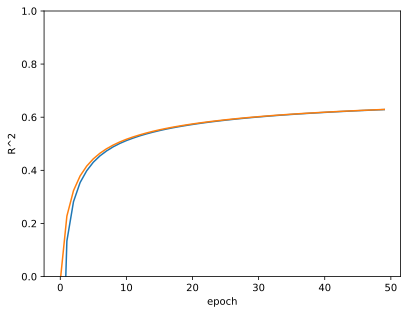

In [167]:
plt.plot([x[0] for x in epoch_r2s])
plt.plot([x[1] for x in epoch_r2s])
plt.xlabel("epoch")
plt.ylabel("R^2")
plt.ylim(0,1)
plt.show()

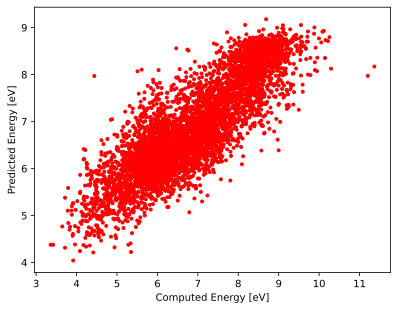

In [168]:
def test(model, iterator, criterion, device):

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:
            
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x).squeeze()

            return y, y_pred




test1, test1_pred = test(model, valid_iterator, criterion, device)

#energy_mean, energy_std

test1= (test1.cpu().numpy()*energy_std.item() +energy_mean.item())*27.211
test1_pred= (test1_pred.cpu().numpy()*energy_std.item() +energy_mean.item())*27.211

plt.plot(test1,test1_pred, 'r.')

plt.xlabel("Computed Energy [eV]")
plt.ylabel("Predicted Energy [eV]")
plt.show()